Overview
--------

The network model we use is exactly as in [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600). The nodes of the network
are all US domestic financial institutions. The connections between
nodes are defined by institutions borrowing from and lending to one
another. There is a link from node $i$ to node $j$ if $i$ has any
payment obligations towards node $j$. In addition to lending to one
another, nodes can borrow and lend to the rest of the domestic and
global economy. These assets and liabilities are termed as *outside* the
financial system. In our application, the *outside* sector is comprised
of domestic and foreign non-financial institutions, governments, and
households, as well as foreign financial institutions.

<a href="#Fig1">Figure 1</a> shows an example of a simple network, taken from [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600). The four arrows
originating in the central node and pointing to the four peripheral
nodes show that the central node owes $10$ to each of the peripheral
nodes. The four peripheral nodes have no borrowing or lending among
themselves. For this network, we say that the central node has *inside
liabilities* of $40$, while each of the peripheral nodes has *inside
assets* of $10$. In practice, we find that inside assets and liabilities
for US financial institutions are primarily composed of deposits, loans
and securities lending transactions.

<figure>
    <img src='../../paper/fig1_networkExample.png' alt='Example of a network' id="Fig1" />
    <figcaption>Figure 1: A simple network</figcaption>
</figure>

In addition to its claims inside the network, the central node has lent
$150$ and has borrowed $100$ from the outside sector, depicted by the
doted lines with arrows going into and out of the central node. We
refer to positive claims with respect to the outside sector as *outside
assets* and to negative claims as *outside liabilities*. Outside assets
typically consist of securities, loans to firms and households
(including mortgages), and public debt. Outside liabilities mostly
involve deposits and lines of credit.

The difference between all assets and all liabilities gives each node’s
net worth. The central node has a net worth of $10$, shown inside the
circle that represents the node. Each of the peripheral nodes has
outside assets of $50$, outside liabilities of $55$ and an inside asset
of $10$ with respect to the central node, for a net worth of $5$.

We will use the following notation for the objects of the network:

$$\begin{aligned}
\bar{p}_{i} &:\text{total liabilities for node }i, \\
f_{i} &:\text{inside liabilities for node }i,\\
b_{i} &:\text{outside liabilities for node }i, \\
a_{i} &:\text{total assets for node }i, \\
d_{i} &:\text{inside assets for node }i, \\
c_{i} &:\text{outside assets for node }i, \\
w_{i} &:\text{net worth for node }i.
\end{aligned}$$

All of the above variables are node-specific, that is, are characteristics of node $i$ when the node is considered in isolation, requiring knowledge of neither how $i$ is connected to other nodes nor of characteristics of other nodes.

We denote the number of nodes of the network by $N$. To keep track of the connections among nodes, we define the $N \times N$ *relative liabilities matrix* $A$ by

$$a_{ij}=\left\{ 
\begin{array}{ccc}
\bar{p}_{ij}/\bar{p}_{i} & , & \text{if }\bar{p}_{i}>0 \\ 
0 & , & \text{if }\bar{p}_{i}=0
\end{array}%
\right.$$

where $\bar{p}_{ij}$ represents the net payments due from $i$ to $j$. Because $a_{ij}$ represents *net* payments, we have that

$$\begin{aligned}
a_{ii} &=0\text{,} &\text{ for }i=1,..,N \\
a_{ij}a_{ji} &=0 \text{,} &\text{ for }i=1,..,N\text{ and }j<i.
\end{aligned}$$

In addition, because payments to $i$ from other nodes $j$ add up to inside assets $d$, we have 

$$\begin{aligned}
\sum_{j=1}^{n}a_{ji}\bar{p}_{j} &=d_{j}\text{,} &\text{ for }i=1,..,N.
\end{aligned}$$

And because payments from $i$ to other nodes add up to inside liabilities $f$, we have

$$\begin{aligned}
\bar{p}_{i}\sum_{j=1}^{n}a_{ij} &=f_{i}\text{,} &\text{ for }i=1,..,N. \\
\end{aligned}$$

Last, by definition, the variables satisfy the following bounds

$$\begin{aligned}
0 &\leq p_{i} \leq \bar{p}_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq c_{i} \leq assets_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq b_{i} \leq \bar{p}_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq a_{ij} \leq 1 & \text{,} & \text{ for }i,j=1,..,N.
\end{aligned}$$

Now we create and plot the network of <a href="#Fig1">Figure 1</a> using Julia.

We start by loading packages to plot networks nicely:

In [383]:
Pkg.add("LightGraphs");Pkg.add("SimpleWeightedGraphs");Pkg.add("Gadfly");Pkg.add("GraphRecipes")
using Plots,LightGraphs,SimpleWeightedGraphs,Gadfly,GraphRecipes

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Now define the network:

In [384]:
p_bar = (55.0, 55.0, 140.0, 55.0, 55.0); # total liabilities
b = (55.0, 55.0, 100.0, 55.0, 55); # outside liabilities
c = (50.0, 50.0, 150.0, 50.0, 50.0); # outside assets
w = (5.0, 5.0, 10.0, 5.0, 5.0); # net worth
A = [0 0 0 0 0; 0 0 0 0 0; 10.0/p_bar[3] 10.0/p_bar[3] 0 10.0/p_bar[3] 10.0/p_bar[3]; 0 0 0 0 0; 0 0 0 0 0]; # matrix of relative liabilities
a = w .+ p_bar; # total assets
d =  a .- c;# inside assets
f = p_bar .- b;# inside liabilities
N = length(c); # number of nodes

And plot the financial network (without outside assets and liabilities)

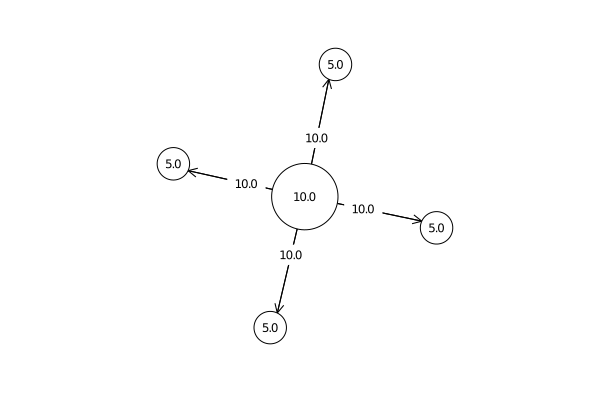

In [385]:
names = w;
Aplot = deepcopy(A)
Aplot[Aplot.<1e-3] .= 0

graphplot(LightGraphs.DiGraph(Aplot),
          nodeshape=:circle,
          markersize = 0.1,
          node_weights = w,
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names = names,
          fontsize = 8,
          linecolor = :darkgrey,
          edgewidth = (s,d,w)->15*Aplot[s,d],
          arrow=true,
          method= :sfdp,
          curves=false,
          edgelabel= p_bar.*A,
    # attributes here: https://docs.juliaplots.org/latest/generated/graph_attributes/
    # method `:spectral`, `:sfdp`, `:circular`, `:shell`, `:stress`, `:spring`, `:tree`, `:buchheim`, `:arcdiagram` or `:chorddiagram`.
          )

To plot the network with outside assets and liabilities that looks like <a href="#Fig1">Figure 1</a>, we create a relative liabilities matrix that includes extra nodes for outside assets and liabilities. For each node inside the network, we define two extra nodes, one for outside assets and another for outside liabilities.

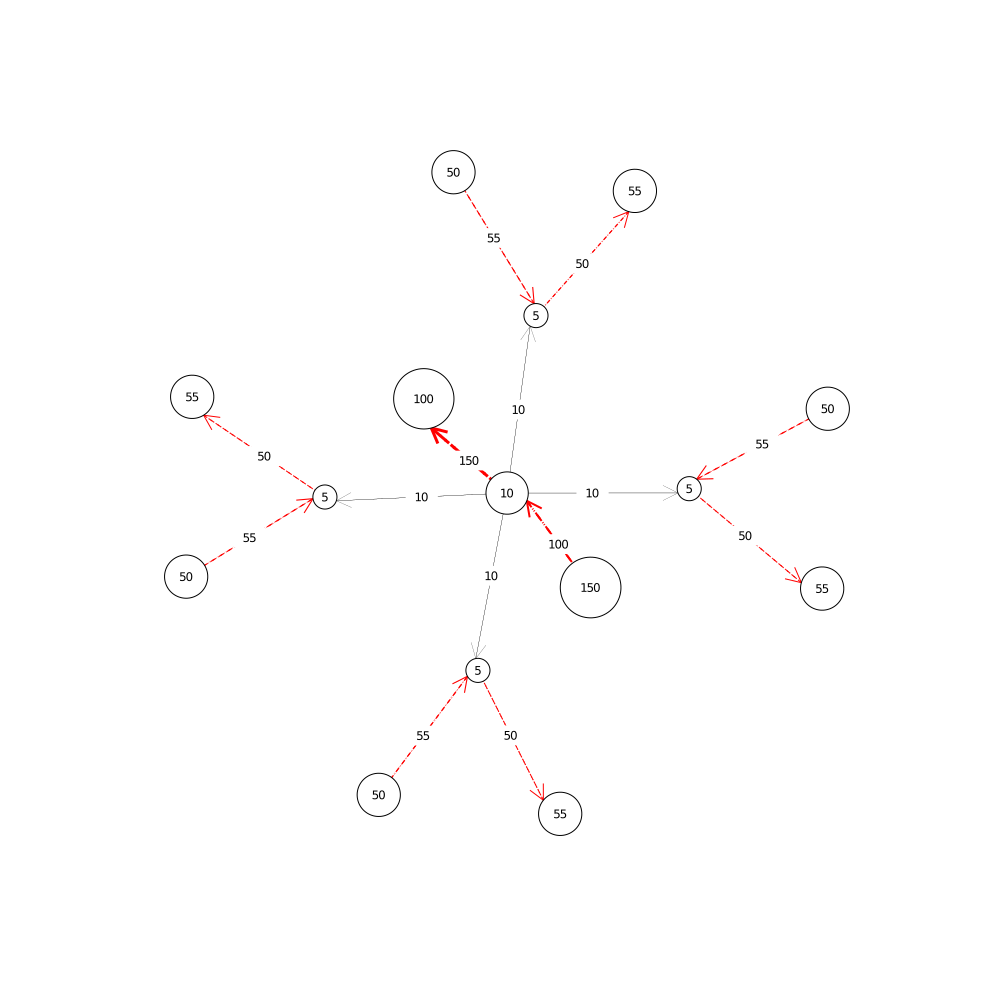

In [387]:
Aall = vcat(hcat(p_bar.*A,Diagonal([c...]),zeros(N,N)),hcat(vcat(zeros(N,N),Diagonal([b...])),zeros(2N,2N))); # relative liabilities matrix
Nall = size(Aall,1); # number of nodes

# plot it
graphplot(LightGraphs.DiGraph(Aall),
          nodeshape=:circle,
          markersize = 0.2,
          node_weights =  [hcat([w...],[b...],[c...]).^(1/30)...],
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names =  trunc.(Int,hcat(w...,b...,c...)),
          fontsize = 8,
          edgecolor = hcat(:red,:red,:black,:black,:black,:black,:red,:red,:red,:red,:red,:red,:red,:red),
          linestyle = hcat(:dashdot,:dashdot,:solid,:solid,:solid,:solid,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot),
          edgewidth = (s,d,w)->0.02*Aall[s,d],
          arrow=true,
          method= :stress,
          curves=false,
          edgelabel= trunc.(Int,Aall),
          axis_buffer=0.25,
          edgelabel_offset=0,
          shorten=0,
          edge_label_box=true,
          layout_kw= Dict(:iterations => 10000),
          size=(1000,1000)
    # attributes here: https://docs.juliaplots.org/latest/generated/graph_attributes/
    # method `:spectral`, `:sfdp`, `:circular`, `:shell`, `:stress`, `:spring`, `:tree`, `:buchheim`, `:arcdiagram` or `:chorddiagram`.
          )

Shocks and Propagation
----------------------

The shocks we consider are exogenous reductions in the value of outside
assets. Therefore, all initial losses always originate outside the
network. One example of such a shock is an increase in defaults for
residential mortgages held by financial institutions.

For sufficiently high initial losses in outside assets, some nodes in
the network will be unable to pay their creditors in full. When this
happens, all debts for the defaulting node (including those outside the
network) are written down pro rata and creditors receive only a fraction
of their promised payments. Note that under a pro rata allocation, a
node defaults on either all of its creditors or none of them. When
creditors for some node are not paid in full, they may themselves be
unable to pay their own creditors, and so on. Initial losses thus get
transmitted inside the network through this “domino” effect. We do not
include in our analysis any liquidity or equity injections, and only net
claims between two nodes are assumed to be of relevance (as opposed to
gross positions). In addition, nodes do not renegotiate claims, even if
it may be mutually beneficial to do so.

As a numerical example, consider what happens when the outside assets of
the central node in <a href="#Fig1">Figure 1</a> receive a shock of size $80$. 
Outside assets for the central node
decrease from $150$ to $70$. Total liabilities are initially $140$.
After the shock, under a pro rata allocation, only $50$ percent of each
liability is repaid as the central node only has $70$ remaining in
assets. Each of the peripheral nodes receives $5$ from the central node,
just enough to balance their assets and liabilities. A shock to the
outside assets of the central node of magnitude greater than $80$ would
reduce the value of assets for peripheral nodes below the value of their
liabilities. In this case, the peripheral nodes would default on their
creditors. In this case, the central node has created contagion to the
peripheral nodes through network contagion. The peripheral nodes default
even though none of their outside assets were affected by the initial
shock.

The Disconnected Network
------------------------

To quantify the amplification of losses stemming from the network
structure –as opposed to the initial losses from exogenous shock to
outside assets– we compare expected losses for the system (the network
plus the outside sector) to the losses in a hypothetical system in which
all connections inside the network have been severed. Both networks are
subject to the same distribution of exogenous shocks to outside assets,
and to no other shocks. We create this hypothetical *disconnected*
system by removing all connections between nodes inside the original
network but keeping the links with the outside sector intact. We also
assume the net worth at each node remains unchanged by creating, for
each node, a fictitious claim to the outside sector equal in value to
the net value of all the connections that were removed. Depending on the
sign of the net value of removed connections, the new fictitious claim
can be an asset or a liability. If it is an asset, we assume it is not
subject to the shocks to outside assets to keep the set of assets
initially shocked identical to that of the original network. If the new
fictitious claim is a liability, we assume it has the same priority as
all other liabilities. In case of default, the new fictitious liability
gets haircut pro rata just like all other non-fictitious liabilities,
and any “losses” imposed on that obligation are counted towards the
value of total system losses. Figure
<a href="#Fig1">Figure 2</a>
shows the disconnected version of network displayed in Figure
<a href="#Fig1">Figure 1</a>.

<figure>
    <img src='../../paper/fig2_networkDisconnected.png' alt='A disconnected network' id="Fig2" />
    <figcaption>Figure 2: A disconnected network</figcaption>
</figure>

In [408]:
b_fict = max.(0,f.-d); # fictitious outside liabilities
c_fict = max.(0,d.-f); # fictitious outside assets

b_fict = (0.0, 0.0, 40.0, 0.0, 0.0)
c_fict = (10.0, 10.0, 0.0, 10.0, 10.0)


(10.0, 10.0, 0.0, 10.0, 10.0)

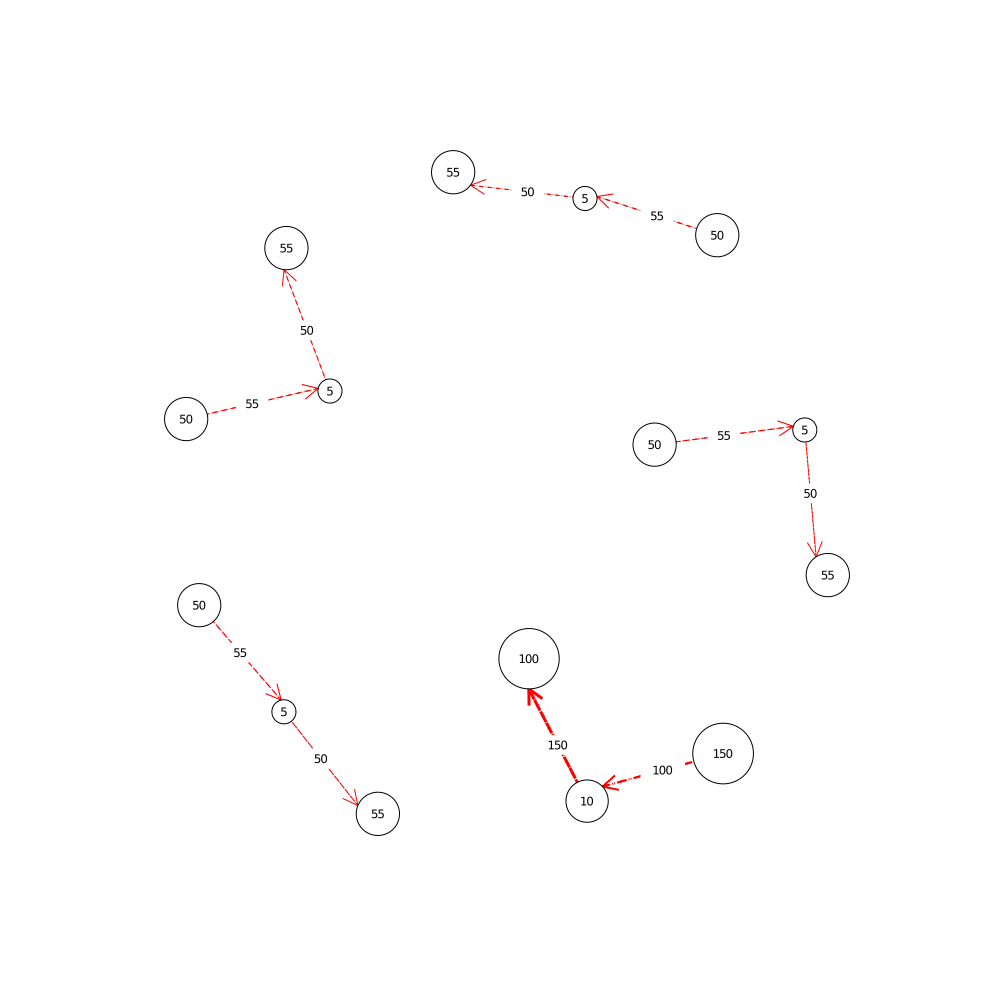

In [398]:
Adis = vcat(hcat(zeros(size(A)),Diagonal([c...]),zeros(N,N)),hcat(vcat(zeros(N,N),Diagonal([b...])),zeros(2N,2N))); # relative liabilities matrix
Nall = size(Aall,1); # number of nodes

# plot it
graphplot(LightGraphs.DiGraph(Adis),
          nodeshape=:circle,
          markersize = 0.2,
          node_weights =  [hcat([w...],[b...],[c...]).^(1/30)...],
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names =  trunc.(Int,hcat(w...,b...,c...)),
          fontsize = 8,
          edgecolor = hcat(:red,:red,:red,:red,:red,:red,:red,:red,:red,:red),
          linestyle = hcat(:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot),
          edgewidth = (s,d,w)->0.02*Adis[s,d],
          arrow=true,
          method= :stress,
          curves=false,
          edgelabel= trunc.(Int,Adis),
          axis_buffer=0.25,
          edgelabel_offset=0,
          shorten=0,
          edge_label_box=true,
          layout_kw= Dict(:iterations => 10000),
          size=(1000,1000)
    # attributes here: https://docs.juliaplots.org/latest/generated/graph_attributes/
    # method `:spectral`, `:sfdp`, `:circular`, `:shell`, `:stress`, `:spring`, `:tree`, `:buchheim`, `:arcdiagram` or `:chorddiagram`.
          )

An Upper Bound on Network Spillovers
------------------------------------

We are interested in whether the expected system losses in our
real-world, interconnected system are substantially greater than those
in the hypothetical *disconnected* system, where node connections have
been excised. We define $R$ to be the ratio of expected losses for the
actual network to the expected losses in the disconnected network. That
is, if $L$ denotes total system losses,

$$R=\frac{E(L_{\text{Actual}})}{E(L_\text{Disconnected})}$$

The value of $R$ gives the relative magnitude of additional losses
imposed on the system because of the interconnected structure of the
network - to wit, network effect losses. With perfect information on the
bilateral claims in the system, this ratio could be calculated exactly
in response to a variety of shocks by using the algorithm to compute the
set of node payments that ‘clear’ the system (i.e. follow the system’s
rules of limited liability and pro rata allocation). In the United
States financial system, detailed and publicly-available data on
bilateral obligations between financial firms does not exist.

The main result in is that a useful upper-bound on $R$ can be derived
without any information on the makeup of each node’s bilateral claims.
We call this upper-bound $B$. If the tails of the distribution of
exogenous shocks to outside assets are not too fat-tailed, then $B$ can
be calculated using node-specific information only[<sup>3</sup>](#fn3).

[Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!) show that $B$
depends only on each node’s total outside assets $c$, each firm’s
probability of default due to direct shocks to outside assets $\delta$,
and the maximum *liability connectivity* among nodes in the system
$\beta^+$. Each node’s liability connectivity is defined as its ratio of
inside liabilities to total liabilities.

[Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!) show that

$$\label{eq:B}
B=1+\frac{1}{(1-\beta ^{+})}\frac{\sum_{i \in S} {\delta _{i}c_{i}}}{\sum_{i \in S}{c_{i}}},$$

$$\begin{aligned}
\bar{\delta}_{i} &:\text{probability of default from outside shocks for node }i, \\
c_{i} &:\text{the dollar value of outside assets for node }i, \\
\beta ^{+} &:\text{maximum liability connectivity, i.e., }\beta^{+}=\max_{i \in S}\beta _{i}\text{, with } \beta_i=\text{the fraction of } \\
& \text{firm i's liabilities held by other nodes in the networks}, \\
S &:\text{Set of financial institution nodes within the network.}\end{aligned}$$

The upper bound $B$ for network spillovers is increasing in the maximum
financial connectivity of the system, $\beta ^{+}$, and in the quantity
$\sum {\delta _{i}c_{i}}/\sum {c_{i}}$, most-easily interpretable as a
weighted average probability of default for the system (with each firm’s
weight given by its share of total outside assets). When $\beta ^{+}$ is
close to $1$, aggregate financial connectivity is high and any initial
shock to outside assets has the potential to be transmitted broadly
across the network. In contrast, when $\beta ^{+}$ is close to zero, any
initial shock dissipates quickly and expected losses should be similar
to those in a truly disconnected network.

For most systems calibrated to real-world data, previous studies have
found that the upper bound $B$ is small. For example, picking
$\beta ^{+}=0.8$ and $\delta _{i}=1$ percent for all nodes $i$, we get
$B=1+0.01/(1-0.8)=1.05$. This means that the connected system has
expected losses that are at most $5$ percent larger than those in the
system of isolated nodes. In their example exercise, find an even
smaller upper bound of $1.0175$ for European banks using data from the
the 2011 European Banking Authority stress test.

The Network Vulnerability Index
-------------------------------

We define the *Network Vulnerability Index* (NVI) to be the upper bound
on the magnitude of additional expected losses created in the system by
network spillovers, expressed as a share of expected disconnected
system:

$$\label{eq:NVI}
NVI=\left( B-1\right) = \frac{1}{(1-\beta ^{+})}\frac{\sum {\delta _{i}c_{i}}}{\sum {c_{i}}}.$$

Being an upper bound, the $NVI$ is most useful when its value is small,
since the model then clearly indicates low vulnerability to potential
network spillovers. When the index is large it is less informative. In
this case, the true value of potential network spillovers could be as
large as the upper bound or as low as zero, as dictated by the bilateral
claims between nodes. The model does not produce any additional
information that can help pinpoint the true value of network spillovers
within that the range $\left[ 0,NVI\right]$. As an extreme, when the
$NVI$ is equal to infinity, it provides no information[<sup>2</sup>](#fn2).

A Firm-Specific Risk Measure: The ‘Contagion Index’
---------------------------------------------------

also presents a firm-specific measure of the potential to cause
contagion, which they term a firm’s ‘contagion index’. For a wide family
of shocks, the index is defined as

$$\text{contagion index} = w_i \beta_i \lambda_i$$

where $w_i$ is a firm’s net worth, $\beta_i$ is liability connectivity
as in equation
<a href="#eq:NVI" data-reference-type="ref" data-reference="eq:NVI">[eq:NVI]</a>,
and $\lambda_i=\frac{c_i}{w_i}$ is the leverage of firm $i$’s outside
assets.

Given that the magnitude of exogenous shocks to outside assets in the
model is bounded by each firm’s actul quantity of outside assets, the
contagion index calculates the total payment shortfall that a firm could
potentially pass on to other nodes following a shock to its own outside
assets. show that an outside asset shock to node $i$ cannot possibly
cause default to node $j$ if node $j$’s net worth is greater than node
$i$’s contagion index. They also show that the *probability* of node $j$
defaulting solely because of a shock to node $i$’s assets *must* be less
than the probability of node $j$ defaulting from a shock to its own
assets if $i$’s contagion index is less than $j$’s quantity of outside
assets, $c_j$[<sup>3</sup>](#fn3).

[1]<span id="fn1">More technically, we consider shocks that have an “increasing
failure rate" (IFR). A random variable with distribution function
$G\left( x\right)$ and density $g\left( x\right)$ is said to have an IFR
if $g\left( x\right) /(1-G\left( x)\right)$ is an increasing function of
$x$ . This family encompasses the normal, exponential, and uniform
distributions. There are no restrictions on the correlation structure of
shocks.

In addition, the joint distribution of potential shocks is assumed to be
invariant to scale (homogeneous in assets). For example, if total assets
of a node double, expected losses are assumed to also double.</span>

[2]<span id="fn2">In this section, we have used the words “small” and “large” to
characterize different levels of the $NVI$ without being explicit about
their meaning. This was a deliberate choice, since the model provides no
welfare analysis and no other indication on how to evaluate the overall
magnitude of the $NVI$. In short, the burden of interpreting what
constitutes small or large values for the $NVI$ is the policymaker’s.</span>

[3]<span id="fn3">The bounds derived by are actually stronger than this - applying to
the probability of node $i$ causing default through contagion to a given
*group* of firms.</span>